# Map Data

This project aligns readings from an ATV-based sampling system to a custom map grid and then aggregates the readings within those grid cells and subcells based on the assumptions below. The purpose of this aggregation is to generalize the reading levels across the geographic region.

* Input data is in a CSV file formatted y, x, reading
* Coordinates (y,x) are in SPC format using US ft within Zone UT C-4302
* Map Survey Units (SU) are named using two letters starting in the lower-left corner of the region as AA (first letter is vertical, second letter is horizontal)
* Each SU is subdivided into 378 cells arranged 21 cells horizontally and 18 cells vertically
* The cells are numbered 1 to 378 starting in the upper-left corner of the cell and proceeding left-to-right and top-to-bottom
* Each cell is 10m x 10m in size
* Each cell should be further divided into subcells that are 1m x 1m
* For reference, the lower-left (South West) corner of Survey Unit AA is (E): 2180160.0001Y (N): 6660000.0000
* For reference, each cell is 32.81 ft x 32.81 ft
* The map area goes from AA to OL (12 horizontal survey units X 15 vertical survey units)


In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(level=logging.DEBUG)

from PIL import Image, ImageDraw, ImageColor

## Convert (x, y) to (SU, Cell, Subcell)


In [2]:
def convert_xy(x, y, 
    units="usft", 
    origin=(2180160.0001, 6660000.0000),
    cell_size=32.81,
    su_grid=(21, 18),
    subcell_grid=10):
    """
    x: SPC Easting in given units
    y: SPC Northing in given units
    origin: (x,y) of the bottom left corner
    cell_size: size of a cell in given units
    su_grid: size of an SU in cells as (width, height)
    subcell_grid: number of subcells to divide each cell into horizontally and vertically

    Converts from SPC format into SU, Cell, Subcell. 
    2180160.0001, 6660000.0000 -> ("AA", 358, 91)

    >>> convert_xy(2180160.0001, 6660000.0000)  
    ('AA', 358, 1)

    >>> convert_xy(2180160.0001 + 32.81*21.01, 6660000.0000)
    ('AB', 358, 1)

    >>> convert_xy(2180160.0001 + 32.81*22.01 + 4, 6660000.0000 + 32.81*19.01 + 4)
    ('BB', 338, 12)
    """

    origin_x = origin[0]
    origin_y = origin[1]
    su_grid_x = su_grid[0]
    su_grid_y = su_grid[1]
    subcell_size = cell_size / subcell_grid

    # 1. How many feet away from the origin are we and how many SUs is that?
    su_x_n = (x - origin_x) // (su_grid_x * cell_size)
    su_y_n = (y - origin_y) // (su_grid_y * cell_size)
    su_x_c = chr(int(65 + su_x_n))
    su_y_c = chr(int(65 + su_y_n))
    su = su_y_c + su_x_c

    logging.debug(f'{x}, {y} is {su_x_n} SUs right and {su_y_n} SUs up from the origin of AA')

    # 2a. Compute the origin of the SU and figure out which Cell we're in
    su_origin_x = origin_x + (su_x_n * su_grid_x * cell_size)
    su_origin_y = origin_y + (su_y_n * su_grid_y * cell_size)
    logging.debug(f'The origin of SU {su} is {su_origin_x}, {su_origin_y}')

    # 2b. Compute how many Cells we are from the origin of the SU we're in
    cell_x_n = (x - su_origin_x) // cell_size
    cell_y_n = (y - su_origin_y) // cell_size
    logging.debug(f'{x}, {y} is {cell_x_n} cells right and {cell_y_n} cells up from the origin of {su}')

    # cell = bottom left cell + cells right - cell rows up
    # cells start in the top left corner and progress left-to-right and top-to-bottom
    cell = int((su_grid_x * (su_grid_y - 1) + 1) + (cell_x_n) - (su_grid_x * cell_y_n))

    # 3a. Compute the origin of the Cell and figure out which Subcell we're in
    cell_origin_x = su_origin_x + (cell_x_n * cell_size)
    cell_origin_y = su_origin_y + (cell_y_n * cell_size)
    logging.debug(f'The origin of cell {su}-{cell} is {cell_origin_x}, {cell_origin_y}')

    # 3b. Compute how many Subcells we are from the origin of the Cell we're in
    subcell_x_n = (x - cell_origin_x) // subcell_size
    subcell_y_n = (y - cell_origin_y) // subcell_size
    logging.debug(f'{x}, {y} is {subcell_x_n} cells right and {subcell_y_n} cells up from the origin of {su}-{cell}')
    
    # subcell = bottom left subcell + subcells right + subcells rows up
    # subcells start in the bottom left corner and progress left-to-right and bottom-to-top
    subcell = int(1 + (subcell_x_n) + (subcell_grid * subcell_y_n))

    return (su, cell, subcell)


In [3]:
convert_xy(2180160.0001 + 32.81*22.01 + 4, 6660000.0000 + 32.81*19.01 + 4)

DEBUG:root:2180886.1481999997, 6660627.7181 is 1.0 SUs right and 1.0 SUs up from the origin of AA
DEBUG:root:The origin of SU BB is 2180849.0100999996, 6660590.58
DEBUG:root:2180886.1481999997, 6660627.7181 is 1.0 cells right and 1.0 cells up from the origin of BB
DEBUG:root:The origin of cell BB-338 is 2180881.8200999997, 6660623.39
DEBUG:root:2180886.1481999997, 6660627.7181 is 1.0 cells right and 1.0 cells up from the origin of BB-338


('BB', 338, 12)

## Read in a whole file of points with readings and convert those to grid locations

In [4]:
import pandas as pd

points = pd.read_csv('SDG-001_Ra226_ScanData_YXReading.csv', dtype=float, header=None)
points.columns = ['Northing','Easting','reading']
points.head()

,Northing,Easting,reading
0,6666833.677,2187712.959,0.27809
1,6666833.668,2187712.959,0.33535
2,6666833.678,2187712.954,0.47949
3,6666833.672,2187712.957,1.10190
4,6666833.682,2187712.958,1.11176


In [5]:
logger.setLevel(level=logging.INFO)

points[['SU','Cell','Subcell']] = points.apply(lambda v: convert_xy(v[1], v[0]), axis=1, result_type='expand')
points.head()

/var/folders/_b/_j786t1s5zl7bhd_071450w80000gn/T/ipykernel_75740/2130198934.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  points[['SU','Cell','Subcell']] = points.apply(lambda v: convert_xy(v[1], v[0]), axis=1, result_type='expand')


,Northing,Easting,reading,SU,Cell,Subcell
0,6666833.677,2187712.959,0.27809,LK,168,23
1,6666833.668,2187712.959,0.33535,LK,168,23
2,6666833.678,2187712.954,0.47949,LK,168,23
3,6666833.672,2187712.957,1.10190,LK,168,23
4,6666833.682,2187712.958,1.11176,LK,168,23


## Do a multi-level aggregation of the readings within the grid locations

* Geometric and Arithmetic Mean of all points in a Subcell
* Arithmetic Mean of the gmean and mean of all Subcells within a Cell
* Arithmetic Mean of all the individual readings in a Cell


In [6]:
# Compute the arithmetic and geometric means at the subcell level

from scipy.stats import gmean

subcell_mean = points.groupby(['SU','Cell','Subcell']).agg({'reading': ['mean', (lambda x: gmean(x)), 'count']}).reset_index()
subcell_mean.columns = ['SU','Cell','Subcell','reading_mean', 'reading_gmean', 'reading_count']
subcell_mean['diff'] = (subcell_mean['reading_gmean'] - subcell_mean['reading_mean']) / subcell_mean['reading_mean']
subcell_mean

/Users/pboal/.pyenv/versions/generic/lib/python3.10/site-packages/scipy/stats/_stats_py.py:197: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


,SU,Cell,Subcell,reading_mean,reading_gmean,reading_count,diff
0,LH,104,8,4.958390,4.958390,1,0.000000
1,LH,104,10,11.788690,7.077628,2,-0.399626
2,LH,104,20,8.212020,8.212020,1,0.000000
3,LH,104,28,2.421935,2.421257,2,-0.000280
4,LH,104,30,2.429155,2.407474,2,-0.008925
...,...,...,...,...,...,...,...
33684,ML,364,94,1.135020,1.135020,1,0.000000
33685,ML,364,96,2.366960,2.366960,1,0.000000
33686,ML,364,97,0.937815,0.860236,2,-0.082723
33687,ML,364,99,1.299360,1.292246,3,-0.005475


In [7]:
# Compute the arithmetic average of the subcell averages
cell_subcell_mean = subcell_mean.groupby(['SU','Cell']).agg({'reading_gmean': 'mean', 'reading_mean': ['mean', 'count'], 'reading_count': 'sum'}).reset_index()
cell_subcell_mean.columns = ['SU','Cell','subcell_gmean','subcell_mean','subcell_count','reading_count']
cell_subcell_mean['gmean_diff'] = (cell_subcell_mean['subcell_gmean'] - cell_subcell_mean['subcell_mean']) / cell_subcell_mean['subcell_mean']
cell_subcell_mean

,SU,Cell,subcell_gmean,subcell_mean,subcell_count,reading_count,gmean_diff
0,LH,104,3.053676,3.430701,13,107,-0.109897
1,LH,105,3.063401,3.092665,46,61,-0.009463
2,LH,125,24.243637,25.424101,10,14,-0.046431
3,LH,126,16.724525,16.815088,43,110,-0.005386
4,LH,147,1.206766,1.209051,15,16,-0.001890
...,...,...,...,...,...,...,...
814,ML,360,1.158834,1.159399,75,229,-0.000487
815,ML,361,1.613139,1.629131,73,122,-0.009816
816,ML,362,1.497794,1.506259,59,75,-0.005620
817,ML,363,1.201393,1.212841,58,74,-0.009439


In [8]:
cell_mean = points.groupby(['SU', 'Cell']).agg({'reading': ['mean', 'count']}).reset_index()
cell_mean.columns = ['SU','Cell','point_mean','point_count']
cell_mean.head()

,SU,Cell,point_mean,point_count
0,LH,104,1.696908,107
1,LH,105,2.868267,61
2,LH,125,24.996896,14
3,LH,126,14.201458,110
4,LH,147,1.215186,16


In [9]:
cells = pd.merge(cell_subcell_mean, cell_mean, how='outer', on=['SU','Cell'])
cells['point_diff'] = (cells['point_mean'] - cells['subcell_mean']) / cells['subcell_mean']
cells

,SU,Cell,subcell_gmean,subcell_mean,subcell_count,reading_count,gmean_diff,point_mean,point_count,point_diff
0,LH,104,3.053676,3.430701,13,107,-0.109897,1.696908,107,-0.505376
1,LH,105,3.063401,3.092665,46,61,-0.009463,2.868267,61,-0.072558
2,LH,125,24.243637,25.424101,10,14,-0.046431,24.996896,14,-0.016803
3,LH,126,16.724525,16.815088,43,110,-0.005386,14.201458,110,-0.155434
4,LH,147,1.206766,1.209051,15,16,-0.001890,1.215186,16,0.005074
...,...,...,...,...,...,...,...,...,...,...
814,ML,360,1.158834,1.159399,75,229,-0.000487,1.080885,229,-0.067719
815,ML,361,1.613139,1.629131,73,122,-0.009816,1.590442,122,-0.023749
816,ML,362,1.497794,1.506259,59,75,-0.005620,1.525121,75,0.012522
817,ML,363,1.201393,1.212841,58,74,-0.009439,1.203128,74,-0.008009


In [10]:
glossary = pd.DataFrame([
    ['Points', 'This sheet contains the raw data points with the SU, Cell, and Subcell location appended to each row'],
    ['Subcells', 'This sheet contains multiple aggregates at the Subcell level: goemetric mean, arithmetic mean, count of readings'],
    ['Cells', 'This sheet contains multiple aggregates at the Cell level: arithmetic mean of the subcell geometric means, arithmetic mean of the subcell arithmetic means, arithmetic mean of all points in that cell, count of subcells with data, count of readings'],
    ['',''],
    ['Notes', 'There appear to be some negative readings, which makes it impossible to compute a geometric mean']
])

In [11]:
with pd.ExcelWriter('SDG-001_Ra226_ScanData_YXReading.xlsx') as writer:
    glossary.to_excel(writer, sheet_name='Glossary', header=False)
    points.to_excel(writer, sheet_name='Points')
    subcell_mean.to_excel(writer, sheet_name='Subcells')
    cells.to_excel(writer, sheet_name='Cells')


<Axes: >

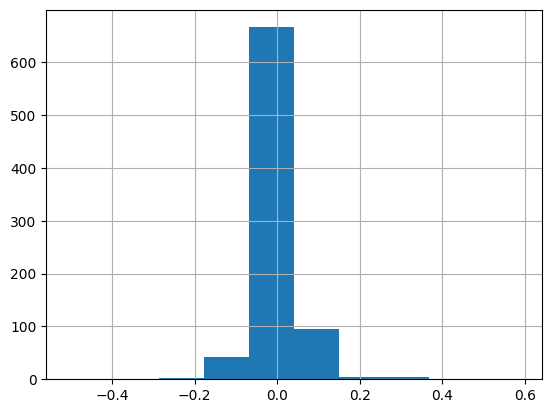

In [12]:
cells['point_diff'].hist()

## Plot a grid with points on it as a demonstration

In [76]:
def plot(xs=[], ys=[], colors=[], shadings={},
    units="usft", 
    origin=(2180160.0001, 6660000.0000),
    cell_size=32.81,
    su_grid=(21, 18),
    subcell_grid=10,
    subcell_size_px=50,
    base_su=(1, 1),
    height_su=3,
    width_su=3,
    subcell_text=False,
    cell_text=False,
    su_text=False,
    level_colors=('red','blue','gray')):
    """
    xs, ys, colors: points to plot with a small dot
    shadings: dictionary of shading color keyed on subcell or cell

    Plots the appropriate grid and a series of given points in that grid
    """

    su_grid_x = su_grid[0]
    su_grid_y = su_grid[1]

    cell_size_px = subcell_size_px * subcell_grid
    su_size_x_px = su_grid_x * cell_size_px
    su_size_y_px = su_grid_y * cell_size_px

    width_px = width_su * su_grid_x * subcell_grid * subcell_size_px
    height_px = height_su * su_grid_y * subcell_grid * subcell_size_px

    img = Image.new("RGBA", (width_px, height_px), "white")
    draw = ImageDraw.Draw(img)
    grid = {}

    # draw the subcell, cell, su grid
    # And build our array of subcell coordinates
    for sx in range(width_su):
        for sy in range(height_su):
            su_x = sx * su_size_x_px
            su_y = sy * su_size_y_px
            su_x_n = base_su[0]-1 + sx
            su_y_n = base_su[1]-1 + height_su - sy - 1
            su_x_c = chr(65+su_x_n)
            su_y_c = chr(65+su_y_n)
            su = su_y_c + su_x_c
            su_box = [su_x, su_y, (sx+1) * su_size_x_px, (sy+1) * su_size_y_px]

            logging.info(f"Drawing SU: {su} at {su_box}")
            draw.rectangle(su_box, None, level_colors[0], 5)

            cell = 1
            for cy in range(su_grid_y):
                for cx in range(su_grid_x):
                    cell_x = su_x + (cx * cell_size_px)
                    cell_y = su_y + (cy * cell_size_px)
                    cell_box = [cell_x, cell_y, cell_x + cell_size_px, cell_y + cell_size_px]
                    # logging.debug(f"Drawing Cell: {su}-{cell} at {cell_box}")
                    if (su, cell) in shadings:
                        cell_color = shadings.get((su, cell))
                    elif su+'-'+str(cell) in shadings:
                        cell_color = shadings.get(su+'-'+str(cell))
                    else:
                        cell_color = None
                    draw.rectangle(cell_box, cell_color, level_colors[1], 3)
                    if cell_text:
                        draw.text([cell_x + cell_size_px/2, cell_y + cell_size_px/2], 
                                f'{su}-{cell}', level_colors[1],
                                anchor='mm', font_size=2*subcell_size_px)

                    subcell = 1
                    for by in range(subcell_grid, 0, -1):
                        for bx in range(subcell_grid):
                            subcell_x = cell_x + (bx * subcell_size_px)
                            subcell_y = cell_y + ((by-1) * subcell_size_px)
                            subcell_box = [subcell_x, subcell_y, subcell_x + subcell_size_px, subcell_y + subcell_size_px]
                            # logging.debug(f"Drawing Subcell: {su}-{cell}-{subcell} at {subcell_box}")
                            if (su, cell, subcell) in shadings:
                                subcell_color = shadings.get((su, cell, subcell))
                            elif su+'-'+str(cell)+'-'+str(subcell) in shadings:
                                subcell_color = shadings.get(su+'-'+str(cell)+'-'+str(subcell))
                            else:
                                subcell_color = None
                            draw.rectangle(subcell_box, subcell_color, level_colors[2], 1)
                            if subcell_text:
                                draw.text([subcell_x + subcell_size_px/2, subcell_y + subcell_size_px/2], 
                                        f'{su}-{cell}-{subcell}', level_colors[2],
                                        anchor='mm', font_size=subcell_size_px/5)

                            # Store the subcell coordinates
                            grid[(su, cell, subcell)] = subcell_box
                            subcell += 1

                    # Store the cell coordinates
                    grid[(su, cell)] = cell_box
                    cell += 1

            # Store the SU coordinates
            grid[(su)] = su_box

            if su_text:
                draw.text([su_x + su_size_x_px/2, su_y + su_size_y_px/2], 
                        f'{su}', level_colors[0],
                        anchor='mm', font_size=20*subcell_size_px)


    # Now plot our points
    for in_x, in_y, color in zip(xs, ys, colors):
        # Distance from origin in given units
        base_x = in_x - origin[0]
        base_y = in_y - origin[1]

        # Size of a pixel in given units
        unit_per_px = cell_size / subcell_grid / subcell_size_px
        base_x_px = base_x / unit_per_px
        base_y_px = base_y / unit_per_px

        # Reset coordinate system
        x_coord = base_x_px
        y_coord = height_px - base_y_px

        # Location info
        loc = convert_xy(in_x, in_y)
        logging.debug(f"Drawing point {in_x}, {in_y} in {loc} at {x_coord}, {y_coord}")
        draw.circle([x_coord, y_coord], 10, color)


    return (img, grid)

In [77]:
cells

,SU,Cell,subcell_gmean,subcell_mean,subcell_count,reading_count,gmean_diff,point_mean,point_count,point_diff,color_std,color,location
0,LH,104,3.053676,3.430701,13,107,-0.109897,1.696908,107,-0.505376,34,#2200ffcc,LH-104
1,LH,105,3.063401,3.092665,46,61,-0.009463,2.868267,61,-0.072558,31,#1f00ffcc,LH-105
2,LH,125,24.243637,25.424101,10,14,-0.046431,24.996896,14,-0.016803,255,#ff00ffcc,LH-125
3,LH,126,16.724525,16.815088,43,110,-0.005386,14.201458,110,-0.155434,168,#a800ffcc,LH-126
4,LH,147,1.206766,1.209051,15,16,-0.001890,1.215186,16,0.005074,12,#0c00ffcc,LH-147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,ML,360,1.158834,1.159399,75,229,-0.000487,1.080885,229,-0.067719,11,#0b00ffcc,ML-360
815,ML,361,1.613139,1.629131,73,122,-0.009816,1.590442,122,-0.023749,16,#1000ffcc,ML-361
816,ML,362,1.497794,1.506259,59,75,-0.005620,1.525121,75,0.012522,15,#0f00ffcc,ML-362
817,ML,363,1.201393,1.212841,58,74,-0.009439,1.203128,74,-0.008009,12,#0c00ffcc,ML-363


## Draw LH to ML with coloring

In [78]:
cells['color_std'] = (cells['subcell_mean'] / cells['subcell_mean'].max() * 255).astype(int)
cells['color'] = cells['color_std'].apply(lambda x: f'#{x:0>2x}00ffcc')
cells['location'] = cells['SU'] + '-' + cells['Cell'].astype(str)
cells

,SU,Cell,subcell_gmean,subcell_mean,subcell_count,reading_count,gmean_diff,point_mean,point_count,point_diff,color_std,color,location
0,LH,104,3.053676,3.430701,13,107,-0.109897,1.696908,107,-0.505376,34,#2200ffcc,LH-104
1,LH,105,3.063401,3.092665,46,61,-0.009463,2.868267,61,-0.072558,31,#1f00ffcc,LH-105
2,LH,125,24.243637,25.424101,10,14,-0.046431,24.996896,14,-0.016803,255,#ff00ffcc,LH-125
3,LH,126,16.724525,16.815088,43,110,-0.005386,14.201458,110,-0.155434,168,#a800ffcc,LH-126
4,LH,147,1.206766,1.209051,15,16,-0.001890,1.215186,16,0.005074,12,#0c00ffcc,LH-147
...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,ML,360,1.158834,1.159399,75,229,-0.000487,1.080885,229,-0.067719,11,#0b00ffcc,ML-360
815,ML,361,1.613139,1.629131,73,122,-0.009816,1.590442,122,-0.023749,16,#1000ffcc,ML-361
816,ML,362,1.497794,1.506259,59,75,-0.005620,1.525121,75,0.012522,15,#0f00ffcc,ML-362
817,ML,363,1.201393,1.212841,58,74,-0.009439,1.203128,74,-0.008009,12,#0c00ffcc,ML-363


In [79]:
shadings = cells[['location','color']].set_index('location').to_dict()['color']

INFO:root:Drawing SU: MH at [0, 0, 2100, 1800]
INFO:root:Drawing SU: LH at [0, 1800, 2100, 3600]
INFO:root:Drawing SU: MI at [2100, 0, 4200, 1800]
INFO:root:Drawing SU: LI at [2100, 1800, 4200, 3600]
INFO:root:Drawing SU: MJ at [4200, 0, 6300, 1800]
INFO:root:Drawing SU: LJ at [4200, 1800, 6300, 3600]
INFO:root:Drawing SU: MK at [6300, 0, 8400, 1800]
INFO:root:Drawing SU: LK at [6300, 1800, 8400, 3600]
INFO:root:Drawing SU: ML at [8400, 0, 10500, 1800]
INFO:root:Drawing SU: LL at [8400, 1800, 10500, 3600]


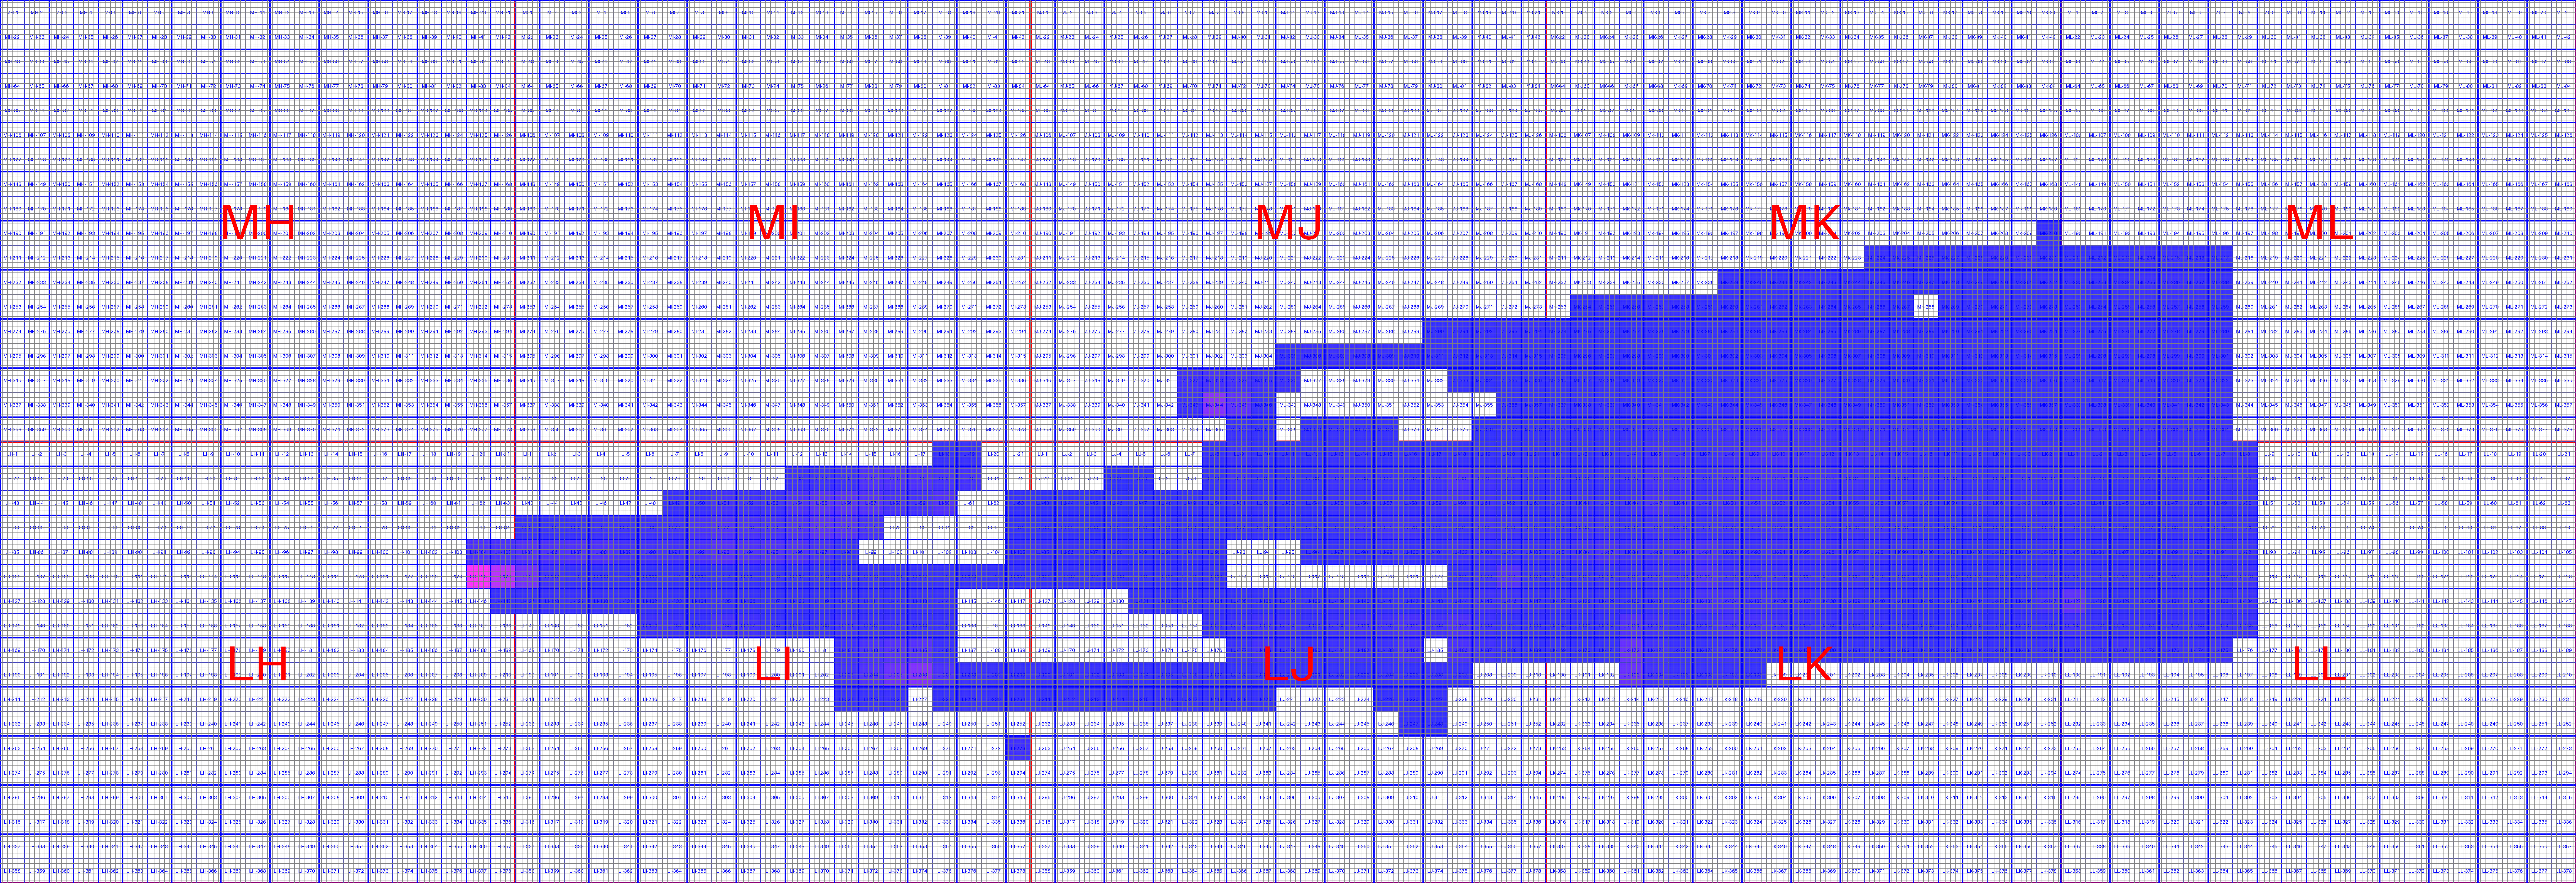

In [80]:
logger.setLevel(level=logging.INFO)

(img, grid) = plot(
    shadings=shadings,
    base_su=(8,12),
    height_su=2, width_su=5,
    # height_su=1, width_su=1,
    subcell_size_px=10,
    cell_text=True,
    su_text=True)
img